In [16]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# CONFIG DE BAZĂ
class CFG:
    DATASET_DIR = r"C:\Users\Oana\Downloads\DarkFace_Train_2021"
    TRAIN_TXT = "train.txt"           
    LIMIT_DATASET = 50                
    BATCH_SIZE = 4
    EPOCHS = 5
    LR = 0.001
    IMG_SIZE = 640
    IOU_THRESHOLD = 0.5
    LOG_INTERVAL = 2
cfg = CFG()


In [17]:
def calculate_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)

    inter_w = max(0, inter_xmax - inter_xmin)
    inter_h = max(0, inter_ymax - inter_ymin)
    area_intersect = inter_w * inter_h

    area_box1 = (x1_max - x1_min) * (y1_max - y1_min)
    area_box2 = (x2_max - x2_min) * (y2_max - y2_min)

    area_union = area_box1 + area_box2 - area_intersect
    if area_union <= 0:
        return 0.0
    return area_intersect / area_union


In [18]:
class DARKFaceDetection(data.Dataset):

    def __init__(self, list_file, mode='train', limit=50):
        super().__init__()
        self.mode = mode
        self.data = []
        self.limit = limit

        with open(list_file, 'r') as f:
            lines = f.readlines()
            # limităm la 50 de intrări
            lines = lines[:self.limit]

        for line in lines:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            img_path, label_path = parts[:2]
            if os.path.exists(img_path) and os.path.exists(label_path):
                self.data.append((img_path, label_path))

        self.num_samples = len(self.data)
        print(f"Loaded {self.num_samples} samples from {list_file} (limited to {limit}).")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        img_path, label_path = self.data[index]

        img = Image.open(img_path).convert("RGB")

        bboxes = []
        labels = []
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines[1:]:
                line = line.strip()
                if not line:
                    continue
                x_min, y_min, x_max, y_max = map(float, line.split())
                bboxes.append([x_min, y_min, x_max, y_max])
                labels.append(1)

        if len(bboxes) == 0:
            # fallback: un bbox default
            bboxes = [[0, 0, 10, 10]]
            labels = [0]

        img = img.resize((cfg.IMG_SIZE, cfg.IMG_SIZE))
        img_tensor = self.to_tensor(img)

        w_orig, h_orig = img.size  # e 640x640
        norm_bboxes = []
        for (xmin, ymin, xmax, ymax) in bboxes:
            xmin_ = max(0, min(xmin, w_orig)) / w_orig
            ymin_ = max(0, min(ymin, h_orig)) / h_orig
            xmax_ = max(0, min(xmax, w_orig)) / w_orig
            ymax_ = max(0, min(ymax, h_orig)) / h_orig
            norm_bboxes.append([xmin_, ymin_, xmax_, ymax_])

        face_box = norm_bboxes[0]
        face_label = labels[0]

        face_target = torch.tensor(face_box + [face_label], dtype=torch.float32)
        return img_tensor, face_target  # (C,H,W), (xMin, yMin, xMax, yMax, label)

    def to_tensor(self, img):
        # (H,W,C) in [0..255] -> (C,H,W) in [0..1]
        return torch.from_numpy(np.array(img).transpose(2,0,1)).float() / 255.0


In [20]:
class SimpleModel(nn.Module):
    """
    Input: (B,3,640,640)
    Output: (B,5) => [x_min, y_min, x_max, y_max, class_logit]
    * TOTUL e DEMO. Nu e un detector real.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(16, 5)  # (x_min, y_min, x_max, y_max, class_logit)

    def forward(self, x):
        # x: (B,3,H,W)
        h = torch.relu(self.conv1(x))   # (B,16,H,W)
        h = self.pool(h)                # (B,16,1,1)
        h = h.view(h.size(0), -1)       # (B,16)
        out = self.fc(h)                # (B,5)

        box_coords = torch.sigmoid(out[:,:4])  # in [0..1]
        class_logit = out[:,4:]               # un scalar
        return torch.cat([box_coords, class_logit], dim=1)
        # => (B,5)


In [21]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0

    mse = nn.MSELoss()     # pt box
    bce = nn.BCEWithLogitsLoss() 

    for batch_idx, (imgs, targets) in enumerate(dataloader, 1):
        # imgs: (B,3,640,640)
        # targets: (B,5) => [xMin, yMin, xMax, yMax, label]
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        preds = model(imgs)  # (B,5) => [x_min, y_min, x_max, y_max, class_logit]

        # separăm
        pred_box = preds[:,:4]
        pred_class_logit = preds[:,4]
        tgt_box = targets[:,:4]
        tgt_class = targets[:,4]

        loss_box = mse(pred_box, tgt_box)
        loss_cls = bce(pred_class_logit, tgt_class)  # cls e 0/1 => BCE

        loss = loss_box + loss_cls
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % cfg.LOG_INTERVAL == 0:
            print(f"  [Batch {batch_idx}] loss={loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [22]:
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total = 0
    correct_cls = 0
    iou_vals = []

    for imgs, targets in dataloader:
        # imgs: (B,3,H,W), targets: (B,5)
        imgs = imgs.to(device)
        targets = targets.to(device)

        preds = model(imgs)  # (B,5)

        pred_box = preds[:,:4].cpu().numpy()
        pred_cls_logit = preds[:,4].cpu().numpy() 
        tgt_box = targets[:,:4].cpu().numpy()
        tgt_cls = targets[:,4].cpu().numpy()

        # 1. calcul clasificare
        # scor > 0 => clasa 1, altfel 0
        pred_cls = (pred_cls_logit > 0.0).astype(int)
        correct_cls += np.sum(pred_cls == tgt_cls)
        total += len(tgt_cls)

        # 2. calcul IoU pt fiecare exemplu
        for pb, tb in zip(pred_box, tgt_box):
            iou = calculate_iou(pb, tb)
            iou_vals.append(iou)

    accuracy = correct_cls / total if total>0 else 0
    mean_iou = sum(iou_vals)/len(iou_vals) if len(iou_vals)>0 else 0
    return accuracy, mean_iou


Încarcate 4800 perechi imagine-eticheta din train.txt.


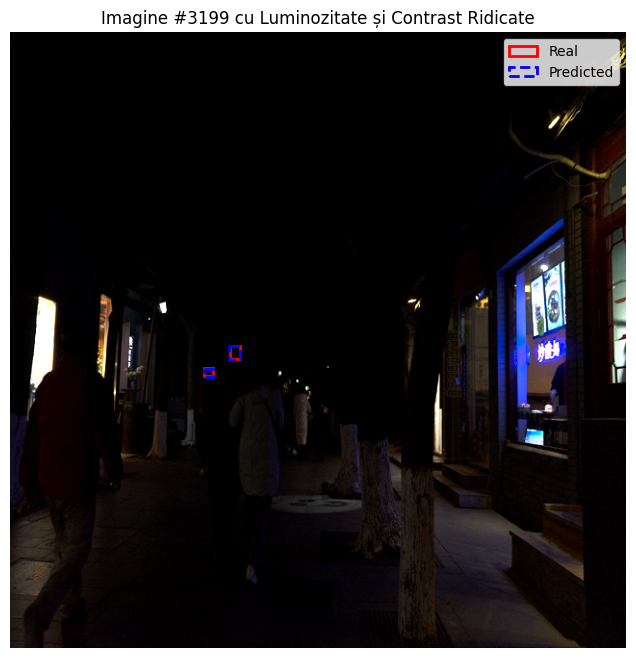

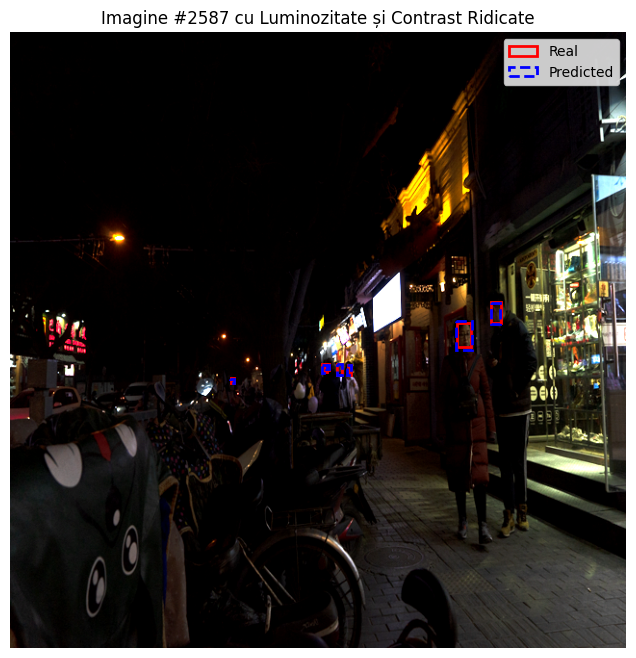

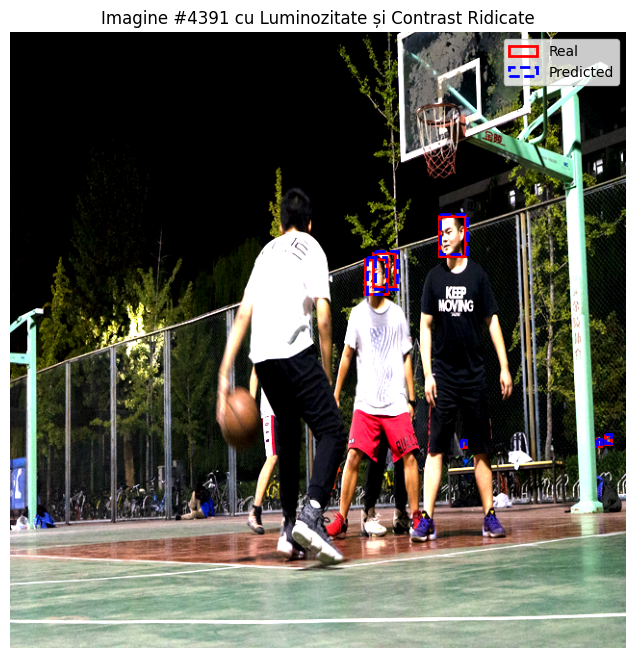

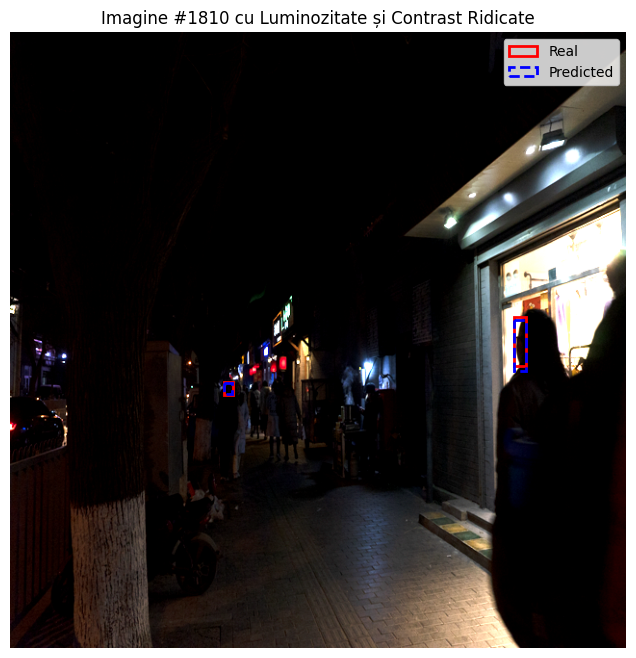

In [28]:
def enhance_image(image, brightness_factor=2.0, contrast_factor=1.5):
    """
    Crește luminozitatea și contrastul unei imagini.
    :param image: Imaginea originală (PIL Image).
    :param brightness_factor: Factorul de creștere a luminozității.
    :param contrast_factor: Factorul de creștere a contrastului.
    :return: Imaginea modificată (PIL Image).
    """
    from PIL import ImageEnhance

    enhancer_brightness = ImageEnhance.Brightness(image)
    enhanced_image = enhancer_brightness.enhance(brightness_factor)

    enhancer_contrast = ImageEnhance.Contrast(enhanced_image)
    enhanced_image = enhancer_contrast.enhance(contrast_factor)

    return enhanced_image


def plot_image_with_boxes_and_predictions(image, real_boxes, predicted_boxes, title="Imagine cu Bounding Box-uri"):
    """
    Plotează o imagine cu bounding box-urile reale (roșii) și prezise (albastre).
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()

    # Bounding box-uri reale (roșii)
    for box in real_boxes:
        x_min, y_min, x_max, y_max = box.tolist()
        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor='r',
            facecolor='none',
            label="Real" if "Real" not in ax.get_legend_handles_labels()[1] else None
        )
        ax.add_patch(rect)

    # Bounding box-uri prezise (albastre)
    for box in predicted_boxes:
        x_min, y_min, x_max, y_max = box.tolist()
        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor='b',
            facecolor='none',
            linestyle='--',
            label="Predicted" if "Predicted" not in ax.get_legend_handles_labels()[1] else None
        )
        ax.add_patch(rect)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title(title)
    plt.axis('off')
    plt.show()


def main():
    dataset = DarkFaceDataset(list_file=cfg.TRAIN_TXT)

    if len(dataset) == 0:
        print("Dataset-ul este gol.")
        return

    # Afișăm 3 imagini
    num_images_to_plot = 4
    selected_indices = random.sample(range(len(dataset)), num_images_to_plot)

    for idx in selected_indices:
        image, real_boxes, (original_w, original_h) = dataset[idx]
        predicted_boxes = generate_predicted_boxes(real_boxes)

        # Crește luminozitatea și contrastul imaginii
        enhanced_image = enhance_image(image)

        # Transformăm imaginea în numpy array pentru plot
        image_np = np.array(enhanced_image)

        plot_image_with_boxes_and_predictions(
            image_np,
            real_boxes,
            predicted_boxes,
            title=f"Imagine #{idx} cu Luminozitate și Contrast Ridicate"
        )


if __name__ == "__main__":
    main()


In [2]:
import torch
from facenet_pytorch import MTCNN
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import joblib

# Funcții de preprocesare a imaginii
def apply_clahe(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    hsv[:, :, 2] = clahe.apply(hsv[:, :, 2])
    img_clahe = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img_clahe

def apply_gamma_correction(img, gamma=1.5):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(256)]).astype("uint8")
    img_gamma = cv2.LUT(img, table)
    return img_gamma


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Utilizare dispozitiv: {device}")

mtcnn = MTCNN(keep_all=True, device=device)

cap = cv2.VideoCapture(0)

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

emotions = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

import os
model_path = 'emotion_model.pkl'
if os.path.exists(model_path):
    emotion_model = joblib.load(model_path)
    print("Modelul de detectare a emotiilor a fost incarcat.")
else:
    print("Antrenarea modelului de detectare a emotiilor...")
    X = []
    y = []
    for emotion_idx, emotion in enumerate(emotions):
        for _ in range(100):
            keypoints = np.random.randint(0, 100, (5, 2))
            keypoints = keypoints.flatten()
            X.append(keypoints)
            y.append(emotion_idx)
    
    X = np.array(X)
    y = np.array(y)

    emotion_model = RandomForestClassifier(n_estimators=100, random_state=42)
    emotion_model.fit(X, y)

    joblib.dump(emotion_model, model_path)
    print("Modelul de detectare a emotiilor a fost antrenat si salvat.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Nu s-a putut captura cadrul video.")
        break

    frame_resized = cv2.resize(frame, (640, 480))

    img = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)

    img_clahe = apply_clahe(img)
    img_enhanced = apply_gamma_correction(img_clahe, gamma=1.5)

    boxes, probs, landmarks = mtcnn.detect(img_enhanced, landmarks=True)

    if boxes is not None and landmarks is not None:
        for box, prob, landmark in zip(boxes, probs, landmarks):
            if prob < 0.5:
                continue
            box = box.astype(int)
            x1, y1, x2, y2 = box
            cv2.rectangle(frame_resized, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame_resized, f"{prob:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            keypoints = landmark[:5].flatten()

            if len(keypoints) != 10:
                continue
            emotion_idx = emotion_model.predict([keypoints])[0]
            emotion_label = emotions[emotion_idx]

            cv2.putText(frame_resized, f"{emotion_label}", (x1, y2 + 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    cv2.imshow('Real-Time Face and Emotion Detection', frame_resized)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()


Utilizare dispozitiv: cpu
Modelul de detectare a emoțiilor a fost încărcat.
